In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os, sys
import scipy.ndimage
import pickle
from multiprocessing import Pool
from skimage import measure, morphology
import random
import pylab
import skimage.transform

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow, figure, hist, plot, scatter, colorbar
get_ipython().magic('matplotlib inline')

np.random.seed(314159)
random.seed(314159)

In [2]:
DATA_PATH = 'D:\\DDSM_Clean'

In [8]:
def get_file_names(path):
    x=[]
    for root, dirs, files in os.walk(path, topdown=False):
        for name in files:
            x.append(os.path.join(root, name))
    return x

In [9]:
file_names = get_file_names(DATA_PATH)

In [10]:
df_mass = pd.read_csv(DATA_PATH + '/mass_case_description_train_set.csv')
df_calc = pd.read_csv(DATA_PATH + '/calc_case_description_train_set.csv')

In [12]:
#Convert file names to a dataframe for Mass-Training Set
df_mass["file_name"] = [ None for x in range(len(df_mass)) ]

for n in range(len(df_mass)):
    key = '\\Mass-Training_' + df_mass["patient_id"][n] +'_'+ df_mass["left or right breast"][n] +'_'+ df_mass["image view"][n]
    for fn in file_names:
        if key in fn:
            df_mass.loc[n, "file_name"] = fn
            break

In [13]:
#Convert file names to a dataframe for Calc-Training Set
df_calc["file_name"] = [ None for x in range(len(df_calc)) ]

for n in range(len(df_calc)):
    key = '\\Calc-Training_' + df_calc["patient_id"][n] +'_'+ df_calc["left or right breast"][n] +'_'+ df_calc["image view"][n]
    for fn in file_names:
        if key in fn:
            df_calc.loc[n, "file_name"] = fn
            break

In [14]:
file_names = list(df_mass["file_name"]) + list(df_calc["file_name"])
breast_density = list(df_mass["breast_density"]) + list(df_calc["breast density"])
print(len(file_names), len(breast_density))

2864 2864


D:\DDSM_Clean\Mass_Train\Mass-Training_P_01367_LEFT_MLO


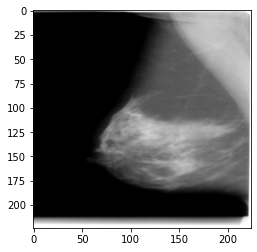

In [15]:
d = pydicom.read_file(file_names[955]) #732 gives error
print(file_names[955])
image = d.pixel_array
image_small = skimage.transform.resize(image, (224,224), preserve_range=True)
imshow(image_small, cmap='gray')
plt.show()

In [ ]:
#WARNING Take Long Time: Create an image file of all images from file_names
images = []
i = 0
for fn in file_names:
    d = pydicom.read_file(fn)
    image = d.pixel_array
    image_small = skimage.transform.resize(image, (224,224), preserve_range=True) #specify image resize
    images.append(image_small)
    i +=1
len(images)

In [183]:
np.save('images.npy', images)

In [3]:
images = np.load('images.npy')

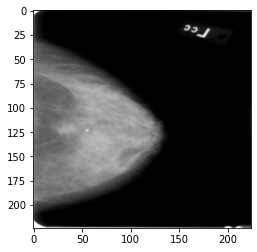

In [4]:
im = images[0] / images[0].max()
plt.imshow(im, cmap='gray')
plt.show()

In [5]:
X = np.stack(images)[...,None]
X = np.repeat(X, 3, axis=-1) #because ImageNet is RGB
X = (X - np.mean(X)) / np.std(X)

In [16]:
y = np.asarray(breast_density)-1
y = y[ :X.shape[0] ]

In [17]:
#np.save('mdata_X.npy', X)
#np.save('mdata_y.npy', y)

In [66]:
X = np.load('mdata_X.npy')
y = np.load('mdata_y.npy')

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, Xception, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam, Nadam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
model_base = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [6]:
x = model_base.layers[-1].output
#x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Dense(512, kernel_initializer='orthogonal', activation='relu')(x)
x = Dense(4, kernel_initializer='orthogonal', activation='softmax')(x)

model2 = Model(model_base.inputs, x)

In [7]:
optimizer = Adam(lr=0.0001)
model2.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)

In [8]:
model2.fit(
    X, 
    y, 
    batch_size=64,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
36/36 [==============================] - 1104s 31s/step - loss: 1.2707 - accuracy: 0.3763 - val_loss: 1.2586 - val_accuracy: 0.2880
Epoch 2/10
36/36 [==============================] - 1066s 30s/step - loss: 1.0770 - accuracy: 0.4998 - val_loss: 0.9040 - val_accuracy: 0.5916
Epoch 3/10
36/36 [==============================] - 1057s 29s/step - loss: 0.8368 - accuracy: 0.6281 - val_loss: 1.0153 - val_accuracy: 0.5148
Epoch 4/10
36/36 [==============================] - 1056s 29s/step - loss: 0.7532 - accuracy: 0.6770 - val_loss: 0.7278 - val_accuracy: 0.6754
Epoch 5/10
36/36 [==============================] - 1056s 29s/step - loss: 0.6850 - accuracy: 0.7128 - val_loss: 0.8359 - val_accuracy: 0.6527
Epoch 6/10
36/36 [==============================] - 1062s 30s/step - loss: 0.5926 - accuracy: 0.7486 - val_loss: 0.7711 - val_accuracy: 0.6300
Epoch 7/10
36/36 [==============================] - 1060s 29s/step - loss: 0.5095 - accuracy: 0.7927 - val_loss: 0.7970 - val_accuracy: 0.6475

In [10]:
model2.save('br_vgg_aug.h5')

In [8]:
model2 = tf.keras.models.load_model('br_vgg_aug.h5')

In [9]:
model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
y_pred = model2.predict(X)

In [11]:
#Assign variables for error analysis.
#y_pred_assigned = [ np.argmax(y_pred[n]) for n in range(len(y_pred)) ]
y_pred_assigned = [ np.round(y_pred[n].dot(np.arange((4)))) for n in range(len(y_pred)) ]
y_pred_conf = [ np.max(y_pred[n]) for n in range(len(y_pred)) ]

In [12]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          do_cell_labels=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm / np.amax(cm), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    if do_cell_labels:
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, y_pred_assigned)
cm

array([[ 416,   43,    3,    0],
       [  40, 1009,   35,    2],
       [   1,  104,  746,   25],
       [   0,    4,  104,  332]], dtype=int64)

Confusion matrix, without normalization
[[ 416   43    3    0]
 [  40 1009   35    2]
 [   1  104  746   25]
 [   0    4  104  332]]


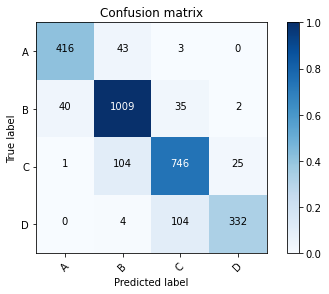

In [14]:
plot_confusion_matrix(cm, ['A', 'B', 'C', 'D'], normalize=False, do_cell_labels=True)

In [24]:
cor = 0
for i in range(len(y)):
    if y[i] == y_pred_assigned[i]:
        cor += 1
        
print("Accuracy:", cor/len(y)*100, "%")

Accuracy: 87.39525139664805 %


In [74]:
for classNum in range(4):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(y)):
        if y[i] == classNum and y_pred_assigned[i] == classNum:
            tp += 1
        elif y[i] != classNum and y_pred_assigned[i] != classNum:
            tn += 1
        elif y[i] != classNum and y_pred_assigned[i] == classNum:
            fp += 1
        elif y[i] == classNum and y_pred_assigned[i] != classNum:
            fn += 1

    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)

    print("Selectivity of class", classNum, ":", round(tpr*100,2),"%")
    print("Specificity of class", classNum, ":", round(tnr*100,2),"%")
    print("")

Selectivity of class 0 : 90.04 %
Specificity of class 0 : 98.29 %

Selectivity of class 1 : 92.91 %
Specificity of class 1 : 91.51 %

Selectivity of class 2 : 85.16 %
Specificity of class 2 : 92.86 %

Selectivity of class 3 : 75.45 %
Specificity of class 3 : 98.89 %

